# Анализ сети фитнес-центров "Культурист-датасаентист".

#### Контекст задачи:
Сеть фитнес-центров «Культурист-датасаентист» разрабатывает стратегию взаимодействия с пользователями на основе аналитических данных.
Распространённая проблема фитнес-клубов и других сервисов — отток клиентов. Как понять, что пользователь больше не с вами? Можно записать в отток тех, кто попросил закрыть договор или удалил аккаунт. Однако клиенты не всегда уходят демонстративно: чаще перестают пользоваться сервисом тихо.
Для фитнес-центра можно считать, что клиент попал в отток, если за последний месяц ни разу не посетил спортзал.
Чтобы бороться с оттоком, отдел по работе с клиентами «Культуриста-датасаентиста» перевёл в электронный вид множество анкет пользователей. Наша задача — провести анализ и подготовить план действий по удержанию клиентов.

#### План работы:
- 1) Выгрузка данных:
  
  - 1a) Импортирование необходимых библиотек.
  - 1b) Первичное знакомство с данными. 
  - 1с) Более глубокое знакомство с данными (методы describe() и info())
  - 1d) Предобработка данных (если необходимо)
  
- 2) Исследовательский анализ данных:
  
  - 2a) Изучение средних значений признаков в двух группах — тех, кто ушел в отток и тех, кто остался.
  - 2b) Построение столбчатых гистограмм и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток)
  - 2с) Построение матрицы корреляций и ее отображение.
  
- 3)  Построение модели прогнозирования оттока пользователей:
  
  - 3a) Разбиение данных на обучающую и валидационную выборку функцией.
  - 3b) Обучение модели на train-выборке двумя способами:
       - логистической регрессией
       - случайным лесом
  - 3с) Оценка метрик accuracy, precision и recall для обеих моделей на валидационной выборке.

- 4) Кластеризация пользователей:
  
  - 4a) Стандартизация данных.
  - 4b) Построение матрицы расстояний функцией linkage() на стандартизованной матрице признаков и создание дендрограммы.
  - 4с) Обучение модели кластеризации на основании алгоритма K-Means и прогнозирование кластеров клиентов.
  - 4d) Изучение средних значений признаков для кластеров.
  - 4е) Построение распределения признаков для кластеров.
  - 4f) Определение для каждого полученного кластера доли оттока.
  
- 5) Общие выводы и предложения.  

## 1.Выгрузка данных

###### 1a. Импортирование необходимых библиотек.

In [1]:
import warnings 
import pandas as pd
import math as mth
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st
import seaborn as sns
from matplotlib import rcParams
import re
import plotly.express as px
import plotly.graph_objects as go
import requests
from numpy import median
from numpy import mean
from io import StringIO
from nltk.stem import SnowballStemmer 
russian_stemmer = SnowballStemmer('russian')

warnings.filterwarnings("ignore")
pd.options.display.max_rows = 999
pd.set_option('display.max_colwidth', -1)

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier

###### 1b.Первичное знакомство с данными

In [2]:
gym_churn = pd.read_csv('/datasets/gym_churn.csv')
gym_churn

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,1,1,1,0,1,12,0,33,2.406023,12.0,8,2.284497,2.349070,0
3996,0,1,0,0,1,1,1,29,68.883764,1.0,1,1.277168,0.292859,1
3997,1,1,1,1,1,12,0,28,78.250542,11.0,2,2.786146,2.831439,0
3998,0,1,1,1,1,6,0,32,61.912657,5.0,3,1.630108,1.596237,0


###### 1c. Более глубокое знакомство с данными (методы describe() и info())

In [3]:
gym_churn.describe()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


In [4]:
gym_churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
gender                               4000 non-null int64
Near_Location                        4000 non-null int64
Partner                              4000 non-null int64
Promo_friends                        4000 non-null int64
Phone                                4000 non-null int64
Contract_period                      4000 non-null int64
Group_visits                         4000 non-null int64
Age                                  4000 non-null int64
Avg_additional_charges_total         4000 non-null float64
Month_to_end_contract                4000 non-null float64
Lifetime                             4000 non-null int64
Avg_class_frequency_total            4000 non-null float64
Avg_class_frequency_current_month    4000 non-null float64
Churn                                4000 non-null int64
dtypes: float64(4), int64(10)
memory usage: 437.6 KB


###### Вывод: 
Первичное и более глубокое знакомство показало что в данных нет пропусков, типы данных соответсвуют необходимым.

###### 1d.Предобработка данных

In [5]:
gym_churn.duplicated().sum()

0

In [6]:
gym_churn.columns = gym_churn.columns.str.lower()
gym_churn

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,1,1,1,0,1,12,0,33,2.406023,12.0,8,2.284497,2.349070,0
3996,0,1,0,0,1,1,1,29,68.883764,1.0,1,1.277168,0.292859,1
3997,1,1,1,1,1,12,0,28,78.250542,11.0,2,2.786146,2.831439,0
3998,0,1,1,1,1,6,0,32,61.912657,5.0,3,1.630108,1.596237,0


###### Вывод: 
Предобрабодка данных показала отсутствие дубликатов.Так же все названия столбцов были приведенны к нижнему регистру, чтобы избежать ненужных ошибок в дальнейшем.

## 2.Исследовательский анализ данных

###### 2a.Изучение средних значений признаков в двух группах — тех, кто ушел в отток и тех, кто остался

In [7]:
grouped_by_churn = gym_churn.groupby('churn').mean()
grouped_by_churn = grouped_by_churn.reset_index()

In [8]:
grouped_by_churn

,churn,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
0,0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


######  2b.Построение столбчатых гистограмм и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток)

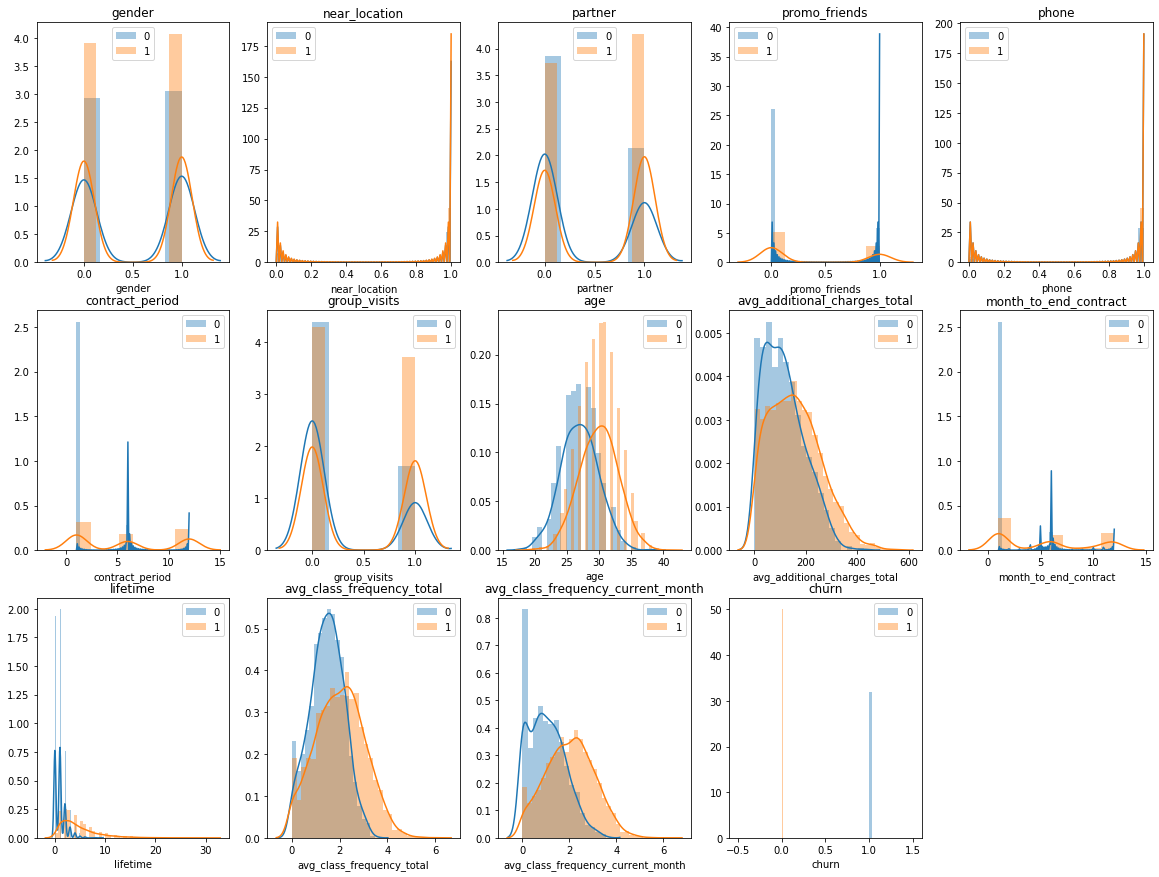

In [9]:
plt.subplots(figsize = (20,15))
plots_in_row = 5

for i,col in enumerate(gym_churn.columns.values):
    sns.distplot(gym_churn.query('churn == 1')[col], ax = plt.subplot(len(gym_churn.columns.values)//plots_in_row + 1,plots_in_row,i+1))
    sns.distplot(gym_churn.query('churn == 0')[col])
    plt.legend(gym_churn['churn'].unique())
    plt.title(col)
    
    
    

##### Вывод: 
Средние значения признаков с разбиением по группам (в оттоке или нет), а так же построение гистограмм и распредедние признаков,показало ожидаемые результаты: 
- в отток ушли пользователи у которых подходил к концу заключенный договор 
- пользователи которые не совсем долго пользуются услугами фитнес-центра 
- которые в основном не приходили по ацкии 'приведи друга' 
- пользователи которые в основном не являются сотрудниками компании-партнёра клуба 
- пользователи у которых в основном небольшие периоды заключения договоров 
- которые меньше посещали груповые занятия.
- средняя частота тех кто ушел в отток был ниже.
- средняя выручка тех кто ушел в отток была ниже.


Так же были немного неожиданные результаты: 
- на отток не влияло растояние до фитнес центра,наоборот расстояние у тех пользователей которые продолжали пользоваться было дальше, чем у тех кто ушел в отток.
- возраст среди тех кто ушел в отток был в среднем ниже

###### 2c.Построение матрицы корреляций и ее отображение

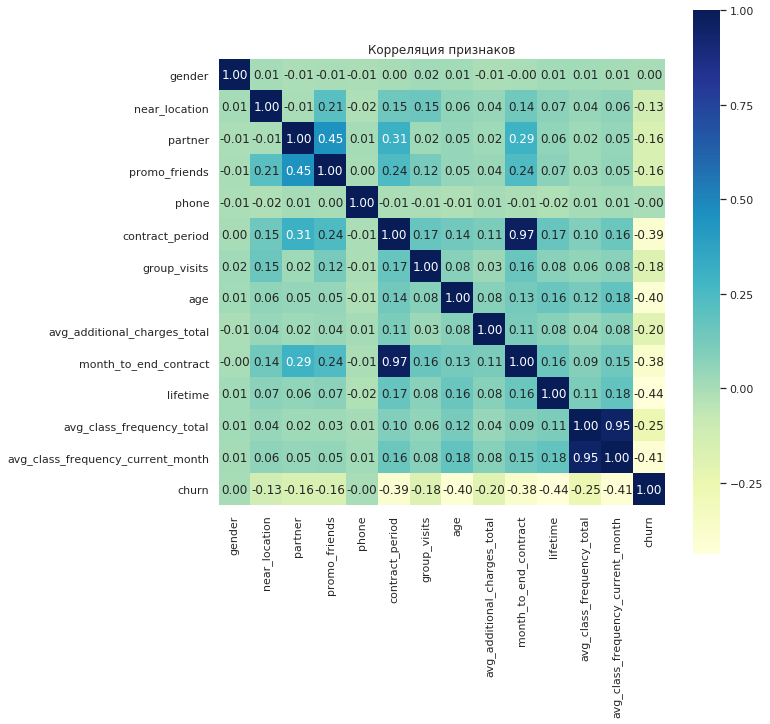

In [10]:
sns.set(rc={'figure.figsize':(10,10)})
ax = sns.heatmap(gym_churn.corr(), annot=True, square=True, cmap="YlGnBu", fmt=".2f")
plt.title('Корреляция признаков');

###### Вывод: 
Среди самых коррелирующих признаков можно выдели такие пары как 'длительность текущего действующего абонемента' и 'срок до окончания текущего действующего абонемента','средняя частота посещений в неделю за все время с начала действия абонемента' и 'средняя частота посещений в неделю за предыдущий месяц'.

###### Дополнение к выводу:
 Так же стоит отметить существенную корреляцию с целевым признаком таких признаков (ожидаемо) как 'Contract_period', 'Age',
 'Month_to_end_contract', 'Lifetime','Avg_class_frequency_total'.
 Так же считаю: можно в дальнейшем провести обучение моделей с и без двух пар самых коррелирующих признаков.

## 3.Построение модели прогнозирования оттока пользователей

###### 3a.Разбиение данных на обучающую и валидационную выборку функцией.

In [11]:
# разделяем данные на признаки (матрица X) и целевую переменную (y)
X = gym_churn.drop('churn', axis = 1)
y = gym_churn['churn']

In [12]:
# разделяем модель на обучающую и валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

###### 3b1.Обучение модели на train-выборке при помощи логистической регрессии.       

In [13]:
# Логистическая регрессия
model = LogisticRegression(random_state = 0)

# обучаем модель
model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=0, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [14]:
# бинарный прогноз
predictions = model.predict(X_test)

###### 3c1.Оценка метрик accuracy, precision и recall на валидационной выборке (логистическая регрессия)

In [15]:
# выведите все изученные метрики для полученного прогноза
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, predictions)))
print('Precision: {:.2f}'.format(precision_score(y_test, predictions)))
print('Recall: {:.2f}'.format(recall_score(y_test, predictions)))

Accuracy: 0.93
Precision: 0.86
Recall: 0.83


###### 3b2.Обучение модели на train-выборке при помощи случайного леса:

In [16]:
# зададим алгоритм для новой модели на основе алгоритма случайного леса
rf_model = RandomForestClassifier(n_estimators = 100,random_state = 0)
rf_model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [17]:
rf_predictions = rf_model.predict(X_test)

###### 3c2.Оценка метрик accuracy, precision и recall на валидационной выборке (cлучайный лес).

In [18]:
# выведем все изученные метрики для полученного прогноза
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, rf_predictions)))
print('Precision: {:.2f}'.format(precision_score(y_test, rf_predictions)))
print('Recall: {:.2f}'.format(recall_score(y_test, rf_predictions)))

Accuracy: 0.92
Precision: 0.84
Recall: 0.82


###### Вывод: 
На основании результатов метрик accuracy, precision и recall лучше себя показала модель логистической регресии, по сравнению со случайным лесом.Правда стоит отметить что различия были незначительными.Так же стоит отметить что уровень качества моделей прогнозирования достаточно высок

## 4.Кластеризация пользователей

###### 4a.Стандартизация данных.

In [19]:
sc = StandardScaler()
x_sc = sc.fit_transform(gym_churn.drop('churn',axis = 1))

###### 4b.Построение матрицы расстояний функцией linkage() на стандартизованной матрице признаков и создание дендрограммы.

In [20]:
linked = linkage(x_sc, method = 'ward')

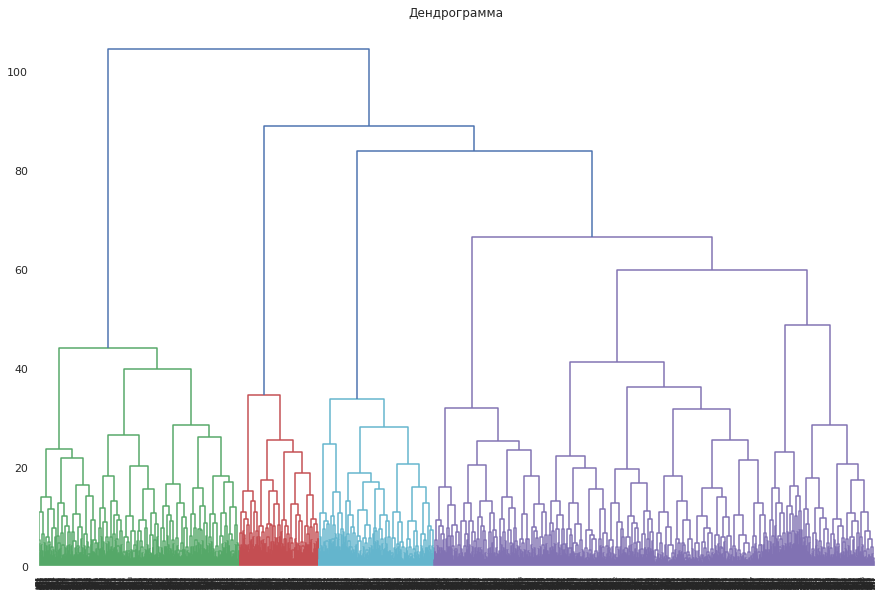

In [21]:
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Дендрограмма')
plt.show()

### Вывод:
На основании полученной дендрограммы, считаю что 3 кластера, можно считать оптимальным количеством.

###### 4c.Обучение модели кластеризации на основании алгоритма K-Means и прогнозирование кластеров клиентов.

In [22]:
km = KMeans(n_clusters = 5,random_state = 0) 
labels = km.fit_predict(x_sc)

In [23]:
gym_churn['cluster_km'] = labels
clastered_gym_avg = gym_churn.groupby(['cluster_km']).mean().T

###### 4d.Изучение средних значений признаков для кластеров.

In [24]:
clastered_gym_avg

cluster_km,0,1,2,3,4
gender,0.502473,0.522078,0.495050,0.485737,0.560335
near_location,0.959446,0.862338,0.000000,1.000000,0.976105
partner,0.783383,0.470130,0.463366,0.350238,0.356033
promo_friends,0.574679,0.306494,0.079208,0.240095,0.229391
phone,1.000000,0.000000,1.000000,1.000000,0.998805
contract_period,10.884273,4.787013,2.352475,1.948494,2.665472
group_visits,0.543027,0.425974,0.215842,0.341521,0.473118
age,29.980218,29.301299,28.477228,28.167987,30.127838
avg_additional_charges_total,160.706969,143.957664,135.457501,131.622204,161.724258
month_to_end_contract,9.950544,4.475325,2.198020,1.856577,2.455197


###### Вывод:
Исходя из таблицы выше можно выделить кластер 0 и 4, так как средние значения признаков в этих кластерах принимают наиболее высокие показатели. 

###### 4e.Построение распределения признаков для кластеров.

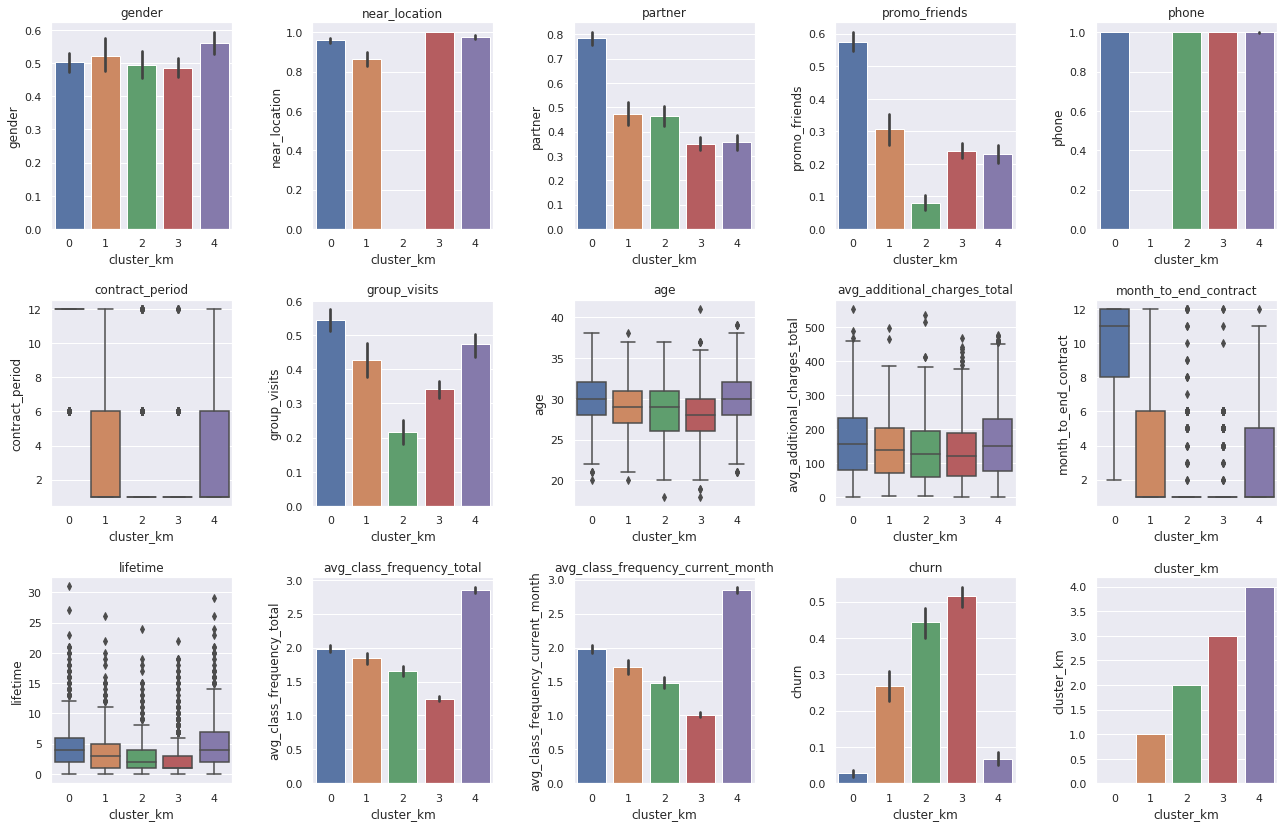

In [25]:
non_binary_vars = ['age','avg_additional_charges_total','lifetime','month_to_end_contract','contract_period']
plt.rcParams['figure.figsize'] = [18,15]
for i,col in enumerate(gym_churn.columns.values):
    ax = plt.subplot(len(gym_churn.columns.values)// plots_in_row + 1, plots_in_row, i+1)
    if col in non_binary_vars:
        sns.boxplot(data = gym_churn, x ='cluster_km', y = col, ax=ax)
    else:
        sns.barplot(data = gym_churn, x ='cluster_km', y = col, ax=ax)
    plt.title(col) 
plt.tight_layout()
plt.show()

###### Вывод:
Судя по графикам выше, можно выделить кластер 0 и кластер 4, как кластеры с самыми оптимальными значениями касательного показателей пользователей нашего фитнес-центра.Самыми малопривлекательными кластерами можно назвать кластер 1 и 2

###### 4f.Определение для каждого полученного кластера доли оттока.

In [26]:
gym_share_churn = gym_churn.groupby('cluster_km').agg({'churn':'mean'})
gym_share_churn

,churn
cluster_km,
0,0.027695
1,0.267532
2,0.443564
3,0.514263
4,0.068100


###### Вывод:
Судя по доле оттока по кластерам больший процент оттока относится к кластерам 1,2,3.
Кластеры 0 и 4, наоборот показывают меньшую долю отток.Стоит учесть это при разработке дальнейших маркетинговых решений. 

## Общие выводы

На основе проделанной работы, можно выдедить следующее:
- 1) К оттоку подверженны пользователи которые подходят по следующим основным признакам: недавно заключили договора, срок договоров минимальный, они не посещали в основном груповые занятияи и не относились к акции 'приведи друга'.
- 2) В свою очередь к признакам которые влияют на отток нельзя отнести пол пользователя, растояние до фитнес-центра, возраст.

Исходя из выше сказанного можного предложить следующии стратегии для службы маркетинга сети:
 - 1) Предлагать пользователям акции, которые будут побуждать их заключать договора на более долгий срок
 - 2) Предлагать пользователям скидки на посещение груповых занятий
 - 3) Обращать внимание на то какими дополнительными услугами пользователь пользуется, при необходимость предлагать дополнительные скидки на эти услуги, особенно в первые месяцы сотрудницества с фитнес-центром.
 - 4) Побуждать пользователей чаще посещать наши фитнес-центры, расширить количество предлагаемых услуг.